# Myo EMG Preprocessing

The Thalmic labs Myo has 3 different modes of EEG sending EEG data:
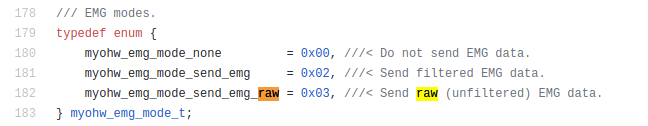

The above image shows the officially supported modes, as listed in the [Myo Bluetooth Protocol here.](https://github.com/thalmiclabs/myo-bluetooth/blob/master/myohw.h)  
As you may notice, 0x01 is strangely missed out, however sending this command gives a 50Hz stream of rectified and filtered sEMG data. 

I have recorded 20 seconds of hand waving to see the difference between these modes.

Modes 1 and 2 were recorded shortly after one another, where as mode 3 was discovered later. 
To keep the positioning similar for all 3 recordings, the position of the main sensor pad with the LED pad was drawn with pen on my hand and subsequent recordings were aligned to this positioning. 

**What is this notebook?**  
This notebook was made to consider how we might filter data coming from the Myo in these different modes and why we might do that. 

**TL;DR for preprocessing raw data**
1. Rectify (Take the absolute value) of the signal. As sEMG data has a positive and negative component, most simple applications only care about the amplitude.
2. Apply a low pass filter to remove 0 readings and reduce noise in the data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
cols = ['One', 'Two', 'Three', "Four", "Five", "Six", "Seven", "Eight", "Rect", "Time_ns"]

df_f = pd.read_csv("20_0x01_filtered.csv")
df_f.columns = cols
df_f['Rect'] = df_f['Rect'] / max(df_f['Rect'])

df_rf = pd.read_csv("20_0x02_raw_filtered.csv")
df_rf.columns = cols
df_rf['Rect'] = df_rf['Rect'] / max(df_rf['Rect'])


df_r = pd.read_csv("20_0x03_raw.csv")
df_r.columns = cols
df_r['Rect'] = df_r['Rect'] / max(df_r['Rect'])


The frequencies of data we recieve using the different modes changes. 

In [3]:
len(df_r)/20, len(df_rf)/20, len(df_f)/20

(199.65, 199.45, 49.65)

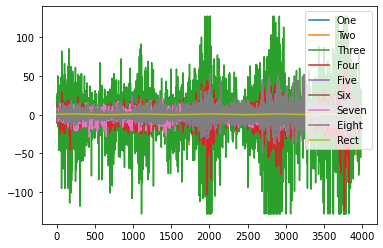

In [4]:
df_r.drop("Time_ns",1).plot()

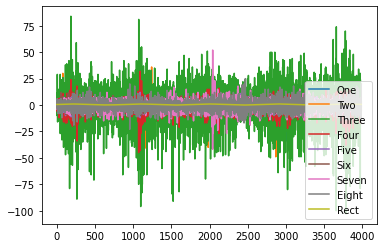

In [5]:
df_rf.drop("Time_ns",1).plot()

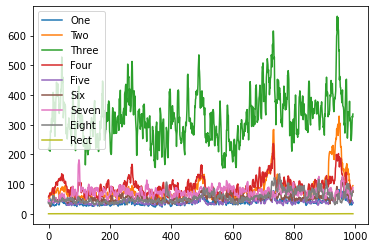

In [6]:
df_f.drop("Time_ns",1).plot()

# Which mode to use?

Looking at the corrolations between the signals and the position of the rectangle. 

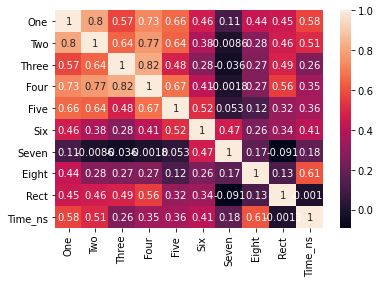

In [7]:
sns.heatmap(df_f.corr(), annot=True)

In the filtered 50Hz signal the Myo provides, we can see a corrolation between channels 3,4 and the position of the rectangle on the screen, rect. 

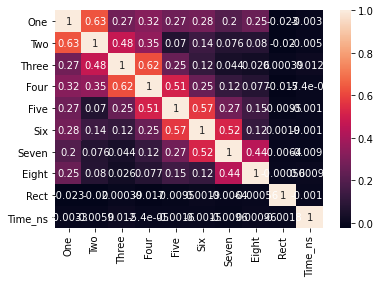

In [8]:
sns.heatmap(df_r.corr(), annot=True)

However, if we look at mode 0x03, the raw unfiltered emg data at 200Hz, we get a very low corrolation. 
If we look back at the plots, one clear reason is that the signal has a mean of 0, due to the positive and negative component of sEMG. 

# Step 1 - Rectification

As we are only interested in the amputn of force applied, we only care about the amplitude of our sEMG signal and therefore can apply rectification. 

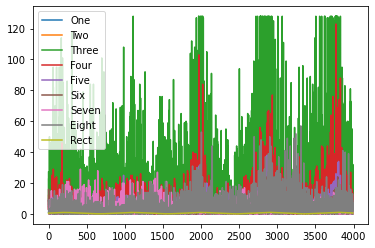

In [9]:
raw_rect = abs(df_r)
raw_rect = raw_rect.drop("Time_ns",1)
raw_rect.plot()

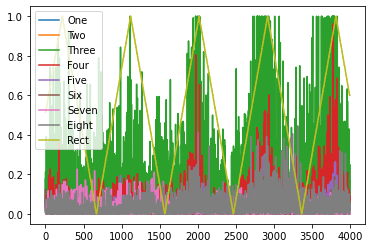

In [10]:
raw_rect_scaled = raw_rect/128
raw_rect_scaled["Rect"] = raw_rect['Rect']
raw_rect_scaled.plot()

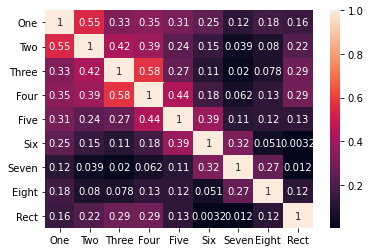

In [11]:
sns.heatmap(raw_rect_scaled.corr(), annot=True)

Rectifying the signal has greatly improved the corrolations, but they are still lower than the 50Hz filtered signal. 

# Filtering the raw rectified signal.

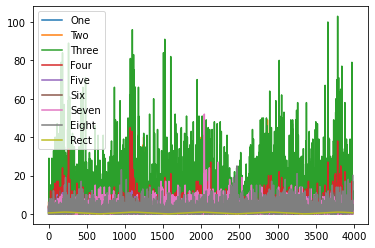

In [12]:
myo_raw_filtered_rect = abs(df_rf)
myo_raw_filtered_rect = myo_raw_filtered_rect.drop("Time_ns",1)
myo_raw_filtered_rect.plot()

In [13]:
myo_raw_filtered_rect['Three'].max()

103.0

<ipython-input-14-f24844779505>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myo_r3['Three'] = myo_r3['Three'] / max(myo_r3['Three'])


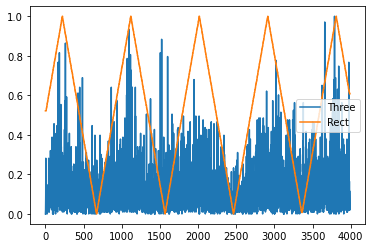

In [14]:
myo_r3 = myo_raw_filtered_rect[['Three','Rect']]
# Applying scaling to the signal
# myo_r3['Three'] = myo_r3['Three']/127
myo_r3['Three'] = myo_r3['Three'] / max(myo_r3['Three'])
myo_r3.plot()

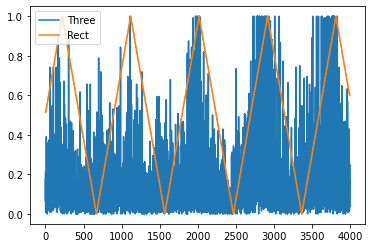

In [15]:
rr3 = raw_rect_scaled[['Three', 'Rect']]
rr3.plot()

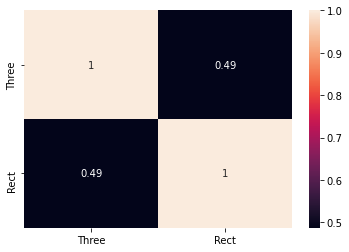

In [16]:
sns.heatmap(df_f[['Three', 'Rect']].corr(), annot=True)

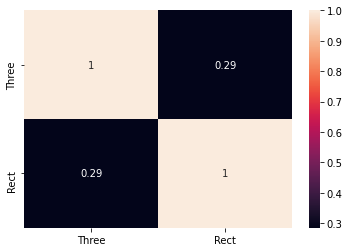

In [17]:
sns.heatmap(rr3.corr(), annot=True)

# The 100hz signals are often 0 valued.

We can see our rectified signal, still is not great. 
If we look at the graphs, the raw output from the sensor, rr3, seems to have 0 values frequently, causing the prediction of the paddle, to hit 0 frequency and be useless for prediction. 

<ipython-input-18-385c74750ebe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myo3['Three'] = myo3['Three'] / max(myo3['Three'])


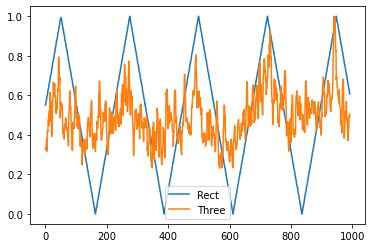

In [18]:
myo3 = df_f[['Rect','Three']]
myo3['Three'] = myo3['Three'] / max(myo3['Three']) 
myo3.plot()

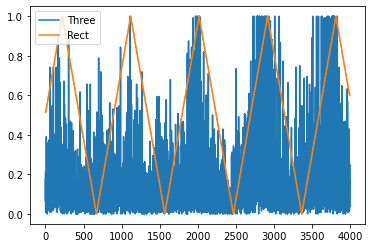

In [19]:
rr3.plot()

## If we zoom into the graph we can see the problem. 

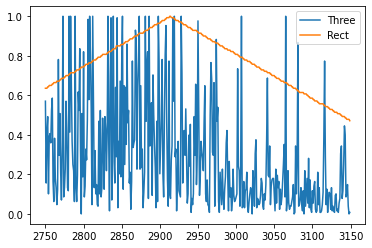

In [20]:
rr3[2750:3150].plot()

As Rect rises, my hand has to move further right and therefore I should be using my muscle to do this, therefore I would not expect a signal at 0. 

We can specifically look for these signals to get an idea of how many there are:

In [21]:
rr3.loc[(rr3['Three'] < 0.2) & (rr3['Rect'] > 0.8)]

,Three,Rect
133,0.031250,0.807143
134,0.046875,0.807143
135,0.132812,0.807143
137,0.179688,0.814286
138,0.132812,0.814286
...,...,...
3892,0.054688,0.821429
3893,0.085938,0.814286
3895,0.179688,0.807143
3896,0.039062,0.807143


In [22]:
high_val = 0.8
low_val = 0.2

high_data = rr3.loc[(rr3['Rect'] > high_val)]

print(len(high_data), "rows in our data should have high muscle activations.")

high_data_but_low_muscle = high_data.loc[(rr3['Three'] < low_val)]

print(len(high_data_but_low_muscle), "rows do not have high values.")

len(high_data_but_low_muscle)/len(high_data) * 100

882 rows in our data should have high muscle activations.
451 rows do not have high values.


51.13378684807256

### High pass filters
As the data sent using mode 0x03, gives values between -128 and 127, the data is bounded and therefore we see some peaking. Using a highpass filter can help remove this. 

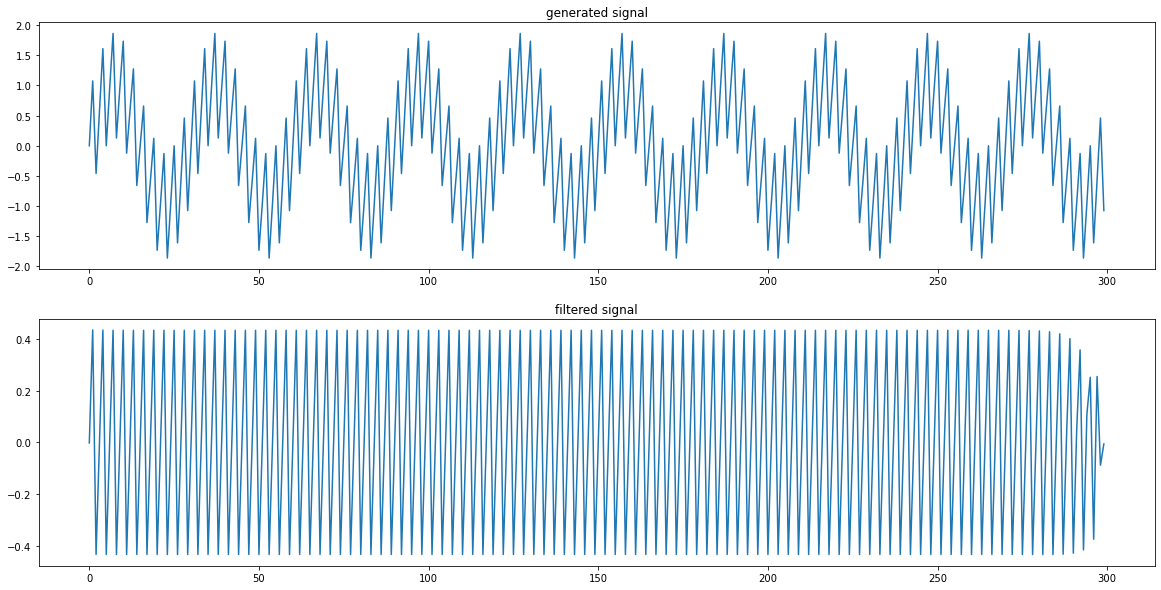

In [25]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

def sine_generator(fs, sinefreq, duration):
    T = duration
    nsamples = fs * T
    w = 2. * np.pi * sinefreq
    t_sine = np.linspace(0, T, nsamples, endpoint=False)
    y_sine = np.sin(w * t_sine)
    result = pd.DataFrame({ 
        'data' : y_sine} ,index=t_sine)
    return result

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

fps = 30
sine_fq = 10 #Hz
duration = 10 #seconds
sine_5Hz = sine_generator(fps,sine_fq,duration)
sine_fq = 1 #Hz
duration = 10 #seconds
sine_1Hz = sine_generator(fps,sine_fq,duration)

sine = sine_5Hz + sine_1Hz

filtered_sine = butter_highpass_filter(sine.data,10,fps)

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(range(len(sine)),sine)
plt.title('generated signal')
plt.subplot(212)
plt.plot(range(len(filtered_sine)),filtered_sine)
plt.title('filtered signal')
plt.show()

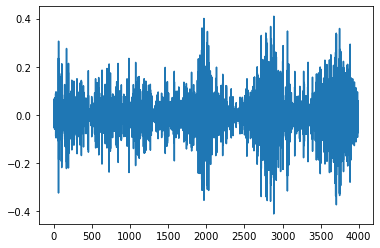

In [26]:
filtered_sine = butter_highpass_filter(rr3['Three'],10,fps)

plt.plot(range(len(filtered_sine)),filtered_sine)

<ipython-input-27-2d8bc61767f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rr3['Filtered'] = filtered_rr3


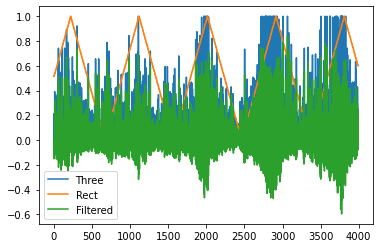

In [27]:
filtered_rr3 = butter_highpass_filter(rr3['Three'],1,fps)

rr3['Filtered'] = filtered_rr3

rr3.plot()

# Low pass filter

A low pass filter attenuates signals with frequencies higher than the cut off frequency.   
The 0x03 data set from the Myo has a lot of high frequency noise which often results in low sEMG data being sent when the muscles are contracted. 

Note that after data has been though a low pass filter, the rate needed to sample this data and recreate it changes, this is why mode 0x01 sends data at 50Hz, instead of the 200Hz the Myo uses otherwise. 

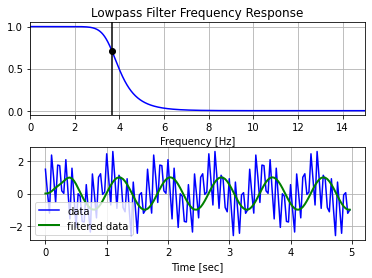

In [29]:
'''
https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
'''
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

<ipython-input-30-fd763adf87c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rr3['Filtered'] = filtered_rr3


Text(0.5, 1.0, 'Lowpass filtered')

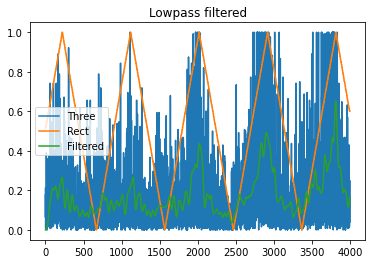

In [30]:
# Filter requirements.
order = 6
fs = 200.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

filtered_rr3 = butter_lowpass_filter(rr3['Three'], cutoff, fs, order)

rr3['Filtered'] = filtered_rr3

rr3.plot()
plt.title('Lowpass filtered')

[Text(0.5, 1.0, 'Correlations to Rect with pre and post filter data')]

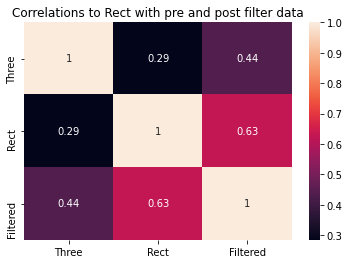

In [34]:
sns.heatmap(rr3.corr(), annot=True).set(title='Correlations to Rect with pre and post filter data')

[Text(0.5, 1.0, 'Myo mode 1 filter')]

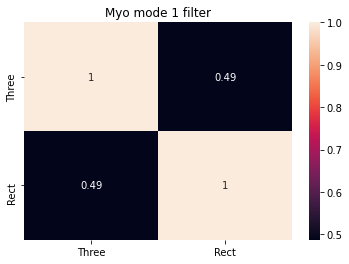

In [35]:
sns.heatmap(df_f[["Three", "Rect"]].corr(), annot=True).set(title='Myo mode 1 filter')

<ipython-input-38-f201f3eefe2f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rr3['Filtered'] = abs(filtered_rr3)


Text(0.5, 1.0, 'Lowpass filtered')

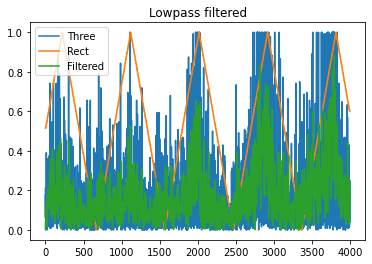

In [38]:
# Filter requirements.
order = 6
fs = 200.0       # sample rate, Hz
cutoff = 25  # desired cutoff frequency of the filter, Hz

filtered_rr3 = butter_lowpass_filter(rr3['Three'], cutoff, fs, order)

rr3['Filtered'] = abs(filtered_rr3)

rr3.plot()
plt.title('Lowpass filtered')

[Text(0.5, 1.0, 'Correlations to Rect with pre and post filter data')]

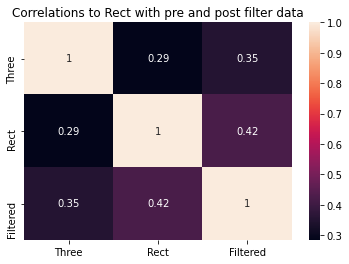

In [39]:
sns.heatmap(rr3.corr(), annot=True).set(title='Correlations to Rect with pre and post filter data')

In [51]:
# Filter requirements.
order = 6
fs = 200.0       # sample rate, Hz
cutoff = 25  # desired cutoff frequency of the filter, Hz

for f in range(1,25):
    filtered_rr3 = butter_lowpass_filter(rr3['Three'], f, fs, order)
    rr3['Filtered'] = abs(filtered_rr3)
    c = rr3.corr()['Filtered']['Rect']
    print(f, c)

1 0.6223238141524972
2 0.6672026591261138
3 0.6446341847942889
4 0.620448234436012
5 0.5991910391376487
6 0.581390785444717
7 0.5651418537058566
8 0.5495200738518483
9 0.5347261069952158
10 0.5219258724643846
11 0.5109851555810286
12 0.5012731590750525
13 0.49234933801882536
14 0.4839825546988019
15 0.4761073911678768
16 0.4689792532570217
17 0.46253548904547964
18 0.4566436572208237
19 0.4512421623955126
20 0.44612082404423853
21 0.44127958935914713
22 0.4365166886775176
23 0.43191183986511555
24 0.4273175320375244


<ipython-input-51-d2d3452b1b53>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rr3['Filtered'] = abs(filtered_rr3)


The corrolation between low pass filtered signal and paddle position is achieved when the filter has a cut off frequency of 2Hz, as shown in the graph below:

<ipython-input-52-070d96e03099>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rr3['Filtered'] = abs(filtered_rr3)


Text(0.5, 1.0, 'Lowpass filtered')

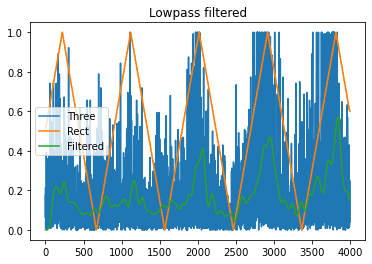

In [52]:
# Filter requirements.
order = 6
fs = 200.0       # sample rate, Hz
cutoff = 2  # desired cutoff frequency of the filter, Hz

filtered_rr3 = butter_lowpass_filter(rr3['Three'], cutoff, fs, order)

rr3['Filtered'] = abs(filtered_rr3)

rr3.plot()
plt.title('Lowpass filtered')

Pygame has capped updates at 60fps, therefore when gathering this training data the paddle moved 10 pixel per second, before hitting the end wall at position:

(Width of the window) - (Width of the paddle) = 1600 - 200 = 1400
Therefore the rising edge must take 140 frames, and one full cycle taking 280 frames. 

So at 60 frames per second, we would expect each cycle to take 14/3 ~ 4.6 seconds to complete. 
Given we have 20 seconds of data, we would therefore expect ~4.28 cycles, which we can see we have. 

So the signal I was following with my hand was 1 cycle in ~4.6 frames, therefore around 0.214 cycles per frame.  

<ipython-input-65-75e4f918cf22>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rr3['Filtered'] = abs(filtered_rr3)


Text(0.5, 1.0, 'Lowpass filtered')

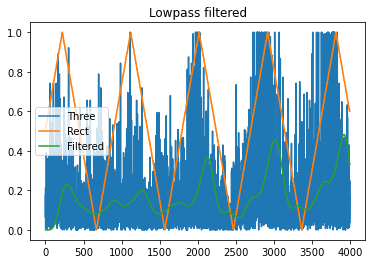

In [65]:
# Filter requirements.
order = 6
fs = 200.0       # sample rate, Hz
cutoff = 4 * 3/14  # desired cutoff frequency of the filter, Hz

filtered_rr3 = butter_lowpass_filter(rr3['Three'], cutoff, fs, order)

rr3['Filtered'] = abs(filtered_rr3)

rr3.plot()
plt.title('Lowpass filtered')

Another interesting question is if we need to care about the latency of the Myo. 